# Малютин Павел, ИТПЗ РАН
 

In [2]:
import pandas as pd
import math 
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from numba import jit, njit
from sklearn.linear_model import LinearRegression

# b-value calculating

In [6]:
'''чтение файла из директории проги
и устранение выбросов значений магнитуды округлением до 1 знака пз.'''
my_cat = pd.read_csv('input1.csv')
my_cat.mag = round(my_cat.mag, 1)  
my_cat.head()

pandas.core.frame.DataFrame

b-value is: 1.098659945063312  ±  0.024982451699328185


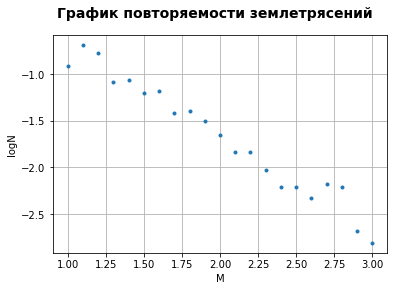

In [98]:
'''Следующий кусок вычисляет необходимые для построения графика повторяемости EQ параметры
а именно: N_tot - суммарное количество землетрясений
a - Series, состоящая из значений lg(N/N_tot) и соотвествующих магнитуд
и, собственно строит график ПЗ для оценки справедливости Г-Р.'''
N_tot = my_cat.shape
f = lambda x: math.log10(x/N_tot[0])
a = my_cat.mag.value_counts().apply(f)
a.plot(style='.')
plt.grid()
plt.xlabel("M")
plt.ylabel("logN")
plt.suptitle('График повторяемости землетрясений', 
             fontsize=14, fontweight='bold')
b_value = 1 / (my_cat['mag'].mean() - my_cat['mag'].min()) * (1/ math.log(10)) # расчет b-value по формуле Aki
# mag - СТОЛБЕЦ С МАГНИТУДОЙ В ДАННОЙ csv

print('\033[1m'+'b-value is:', b_value, ' ± ', b_value/math.sqrt(N_tot[0]))

In [99]:
b_val = pd.DataFrame({'Mags': a.index, 'LogN': a.values})
Mags = b_val.Mags.to_numpy().reshape(-1, 1)
LogN = b_val.LogN.to_numpy().reshape(-1, 1)
A = LinearRegression()
A.fit(Mags, LogN)
print('\033[1m' + 'Wrong b-value is', -A.coef_[0])

Wrong b-value is [0.98591505]


In [108]:
Mags1 = b_val.drop([2,4,16,18]).Mags.to_numpy().reshape(-1, 1)
LogN1 = b_val.drop([2,4,16,18]).LogN.to_numpy().reshape(-1, 1)
B = LinearRegression()
B.fit(Mags1, LogN1)
print('\033[1m' + 'Better b-value is', -B.coef_[0])

Better b-value is [1.07368867]


# Fractal dimension
#### но, прежде всего, функция вычисления расстояния между землетрясениями


In [101]:
global Pi2, RAD, FLAT
Pi2 = math.pi/2 # тупо пи-на-два
RAD = 0.01745329 # DGR -> RAD
FLAT = 0.993231 # поправка на эллипсоидноть

In [102]:
@njit
def eq_dist (fi1, la1, fi2, la2, d1, d2): # fi - широта (latitude), la - долгота (longtitude)
    '''Функция позволяет вычислять расстояение между двумя точками земли с учетом сплюсности и глубины'''    
    if ((fi1-fi2)==0 and (la1-la2)==0): #проверка на расстояние между одним и тем же землетрясением
        return (0.0)  
    col1 = Pi2 - math.atan(FLAT * math.tan(fi1 * RAD))
    col2 = Pi2 - math.atan(FLAT * math.tan(fi2 * RAD))
    
    dlon =  la2 * RAD - la1 * RAD
    
    cosdel = math.sin(col1) * math.sin (col2) * math.cos(dlon) + math.cos(col1) * math.cos(col2)
    delr = math.acos(cosdel)
    colat = Pi2 - (fi1 * RAD + fi2 * RAD) / 2.0
    return math.sqrt((delr * 6371.227 * (1.0 + 0.00337853 * (1./3. -((math.cos(colat))*math.cos(colat)))))**2 + (d2-d1)**2)

## Непосредственный расчёт фрактальной размерности

In [103]:
'''создание numpy-array для более быстрого обращения [к памяти]
в цикле к соответствующим значениям широты и долготы'''
latitude = my_cat.latitude.to_numpy()
longitude = my_cat.longitude.to_numpy()
depth = my_cat.depth.to_numpy()

In [104]:
'''Вместо того, чтобы каждый раз перебирать для каждого заданного расстояния между
землетрясениями все возможные пары расстояний, в самом начале создается массив
с этими парами. Это существенно сокращает время выполнения программы'''

array_of_dist = []
for k in tqdm(range((N_tot[0]))):
    for j in range(k+1, N_tot[0]):
        array_of_dist.append(eq_dist(latitude[k], longitude[k], latitude[j], longitude[j], depth[k], depth[j]))

100%|█████████████████████████████████████| 1934/1934 [00:05<00:00, 369.71it/s]


In [105]:
fractalka = pd.DataFrame(dtype='float')  #ДФ с lg(N/N_0) и lg(A)
X = np.linspace(0.09,2,50)                 #задает равномерно распределенный массив возможных расстояний м/у ЗТ
total_pairs = N_tot[0]*(N_tot[0]-1)/2    #общее количество пар землетрясений 
for i in tqdm(X):  
    element_count = len([item for item in array_of_dist if item < i])  #количество эл-в меньше определенного расстояния 
    fractalka = pd.concat([fractalka, pd.DataFrame ([math.log10(element_count/total_pairs)],[math.log10(i)])])
    #объединение старого массива для расчета FD и новых данных с lg(N/N_0) и lg(A)

100%|██████████████████████████████████████████| 50/50 [00:12<00:00,  3.94it/s]


Text(0, 0.5, 'log(N/N_0)')

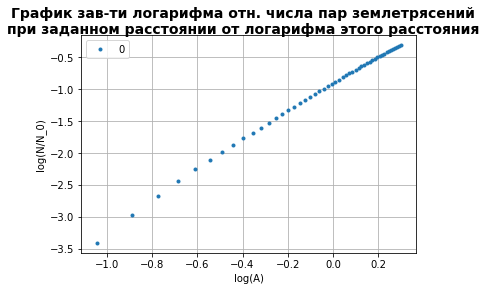

In [106]:
fractalka.plot(style='.')
plt.suptitle('График зав-ти логарифма отн. числа пар землетрясений' '\nпри заданном расстоянии от логарифма этого расстояния', 
             fontsize=14, fontweight='bold')
plt.grid()
plt.xlabel("log(A)")
plt.ylabel("log(N/N_0)")

In [107]:
X = fractalka.index.to_numpy().reshape(-1, 1)
Y = fractalka[0].to_numpy().reshape(-1, 1)
linear_model = LinearRegression()
linear_model.fit(X, Y)
print('\033[1m' + 'Fractal dimension is', linear_model.coef_[0][0])

Fractal dimension is 2.2207299691916114
